In [1]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score

# Reading Data

In [2]:
feature_path = '../Data/Features/resnet18_features.pt'
data = torch.load(feature_path)
for key, value in data.items():
    print(f'{key.capitalize()} Data (X, y): ', value[0].shape, value[1].shape)

Train Data (X, y):  (60000, 512) (60000,)
Test Data (X, y):  (10000, 512) (10000,)


# Data Splitting

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data['train'][0], data['train'][1], test_size = 5000, stratify = data['train'][1], random_state = 10)
data['train'] = [X_train, y_train] 
data['val'] = [X_val, y_val]

for key, value in data.items():
    print(f'{key.capitalize()} Data (X, y): ', value[0].shape, value[1].shape)

Train Data (X, y):  (55000, 512) (55000,)
Test Data (X, y):  (10000, 512) (10000,)
Val Data (X, y):  (5000, 512) (5000,)


# Data Transformation

## PCA

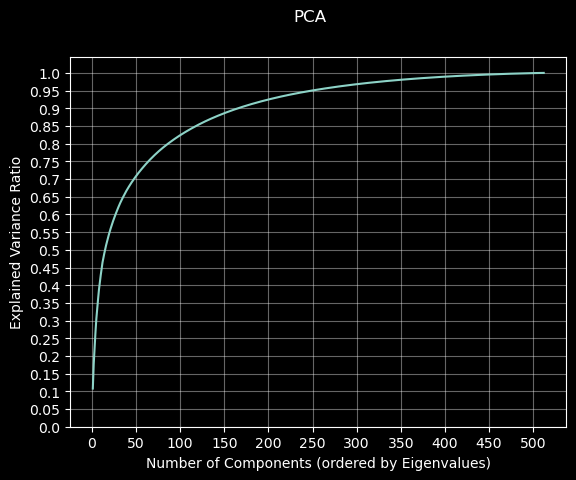

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA()
scalar = StandardScaler().fit(data['train'][0])
pca.fit(scalar.transform(data['train'][0]))
explained_variance_ratios = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(explained_variance_ratios)+1), explained_variance_ratios)
plt.xlabel('Number of Components (ordered by Eigenvalues)')
plt.ylabel('Explained Variance Ratio')
plt.suptitle('PCA')
plt.yticks(np.array(range(0, 105, 5))/100, np.array(range(0, 105, 5))/100)
plt.xticks(range(0, len(explained_variance_ratios)+1, 50), range(0, len(explained_variance_ratios)+1, 50))
plt.grid(True, alpha=0.4)
plt.show()

data['train'][0] = pca.transform(scalar.transform(data['train'][0]))
data['val'][0] = pca.transform(scalar.transform(data['val'][0]))
data['test'][0] = pca.transform(scalar.transform(data['test'][0]))

## Normalization

In [14]:
scalar = StandardScaler().fit(*data['train'])

data['train'][0] = scalar.transform(data['train'][0])
data['val'][0] = scalar.transform(data['val'][0])
data['test'][0] = scalar.transform(data['test'][0])

## Anova Test

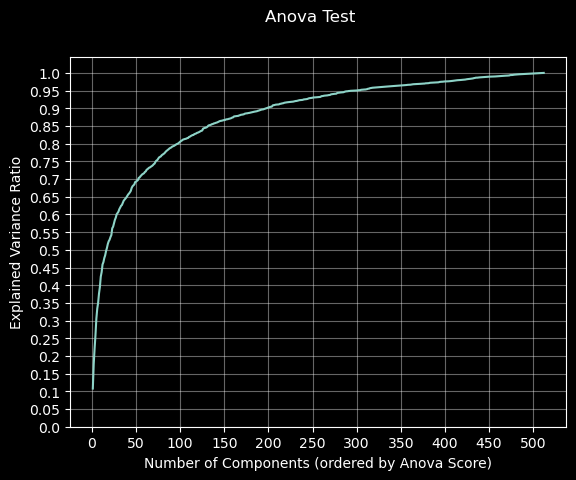

In [15]:
from sklearn.feature_selection import f_classif

scores, _ = f_classif(*data['train'])

feature_score = list(zip(range(0, data['train'][0].shape[1]), scores))
feature_score = sorted(feature_score, key=lambda item: item[1], reverse=True)

feature_ordering = [item[0] for item in feature_score]

data['train'][0] = data['train'][0][:, feature_ordering]
data['val'][0] = data['val'][0][:, feature_ordering]
data['test'][0] = data['test'][0][:, feature_ordering]

explained_variance_ratios = np.cumsum(pca.explained_variance_ratio_[feature_ordering])

plt.plot(range(1, len(explained_variance_ratios)+1), explained_variance_ratios)
plt.xlabel('Number of Components (ordered by Anova Score)')
plt.ylabel('Explained Variance Ratio')
plt.suptitle('Anova Test')
plt.yticks(np.array(range(0, 105, 5))/100, np.array(range(0, 105, 5))/100)
plt.xticks(range(0, len(explained_variance_ratios)+1, 50), range(0, len(explained_variance_ratios)+1, 50))
plt.grid(True, alpha=0.4)
plt.show()

## Feature Subsets

In [16]:
min_ev = 0.85
max_ev = 0.98
delta = 0.01

print(f'Component Numbers for an increase in explained variance ratio of {delta} starting from an explained variance ratio of {min_ev} and stopping at an explained variance ratio of {max_ev}')

n_components = []
for n_component, ev in enumerate(explained_variance_ratios):
    if ev>=min_ev and ev<=max_ev:
        n_components.append(n_component+1)
        min_ev += delta

print(n_components)

Component Numbers for an increase in explained variance ratio of 0.01 starting from an explained variance ratio of 0.85 and stopping at an explained variance ratio of 0.98
[132, 142, 155, 167, 184, 198, 208, 231, 251, 273, 298, 328, 378]


# Models

## Gaussian Naive Bayes

Training:


100%|██████████| 13/13 [00:02<00:00,  6.19it/s]


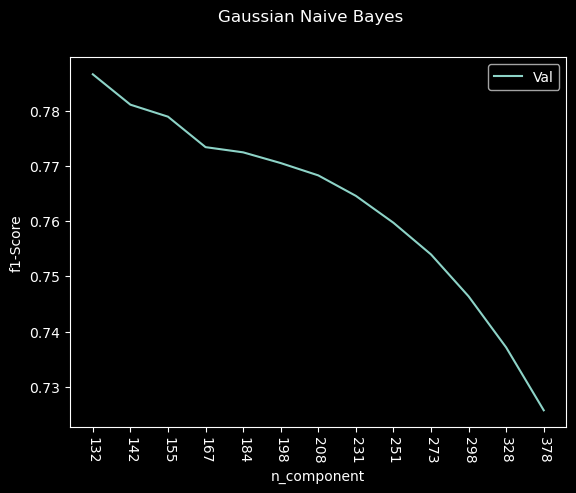

Maximum Validation F1-Score:  0.7867251148849774


In [17]:
from sklearn.naive_bayes import GaussianNB
np.random.seed(10)

val_f1_scores = []

print('Training:')
for n_component in tqdm(n_components):

    clf = GaussianNB().fit(data['train'][0][:,:n_component], data['train'][1])

    val_preds = clf.predict(data['val'][0][:,:n_component])

    val_f1_scores.append(f1_score(data['val'][1], val_preds, average='macro'))

plt.plot(range(1, len(val_f1_scores)+1), val_f1_scores, label = 'Val')
plt.xticks(range(1, len(n_components)+1), n_components, rotation=-90)
plt.xlabel('n_component')
plt.ylabel('f1-Score')
plt.suptitle('Gaussian Naive Bayes')
plt.legend()
plt.show()

print('Maximum Validation F1-Score: ', max(val_f1_scores))

## Nearest Neighbour

Training:


100%|██████████| 13/13 [03:15<00:00, 15.05s/it]


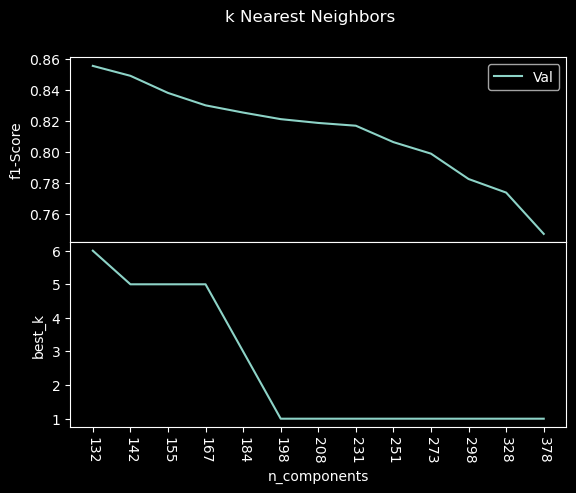

Maximum Validation F1-Score:  0.8556974952340619


In [18]:
from sklearn.neighbors import KNeighborsClassifier
np.random.seed(10)

max_k = 10

val_f1_scores = []
best_ks = []

print('Training:')
for n_component in tqdm(n_components):
    k_f1_scores = []
    for k in range(1, max_k+1):
        
        clf = KNeighborsClassifier(k, n_jobs=-1).fit(data['train'][0][:,:n_component], data['train'][1])

        val_preds = clf.predict(data['val'][0][:,:n_component])

        k_f1_scores.append(f1_score(data['val'][1], val_preds, average='macro'))

    val_f1_scores.append(max(k_f1_scores))
    best_ks.append(k_f1_scores.index(max(k_f1_scores))+1)


fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.subplots_adjust(hspace=0)

ax[0].plot(range(1, len(val_f1_scores)+1), val_f1_scores, label = 'Val')
ax[0].set_xticks(range(1, len(n_components)+1))
ax[0].set_ylabel('f1-Score')
ax[0].legend()

ax[1].plot(range(1, len(val_f1_scores)+1), best_ks)
ax[1].set_xticks(range(1, len(n_components)+1), n_components, rotation=-90)
ax[1].set_xlabel('n_components')
ax[1].set_ylabel('best_k')
fig.suptitle('k Nearest Neighbors')
plt.show()

print('Maximum Validation F1-Score: ', max(val_f1_scores))

## Decision Tree

Training:


100%|██████████| 13/13 [07:40<00:00, 35.43s/it]


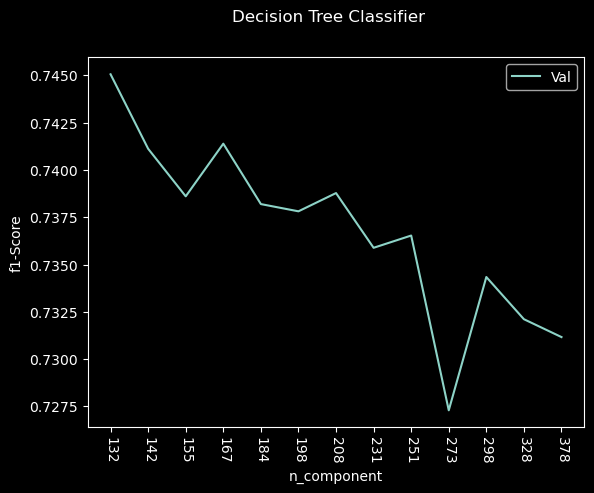

Maximum Validation F1-Score:  0.7450618851652087


In [19]:
from sklearn.tree import DecisionTreeClassifier
np.random.seed(10)

val_f1_scores = []

print('Training:')
for n_component in tqdm(n_components):

    clf = DecisionTreeClassifier().fit(data['train'][0][:,:n_component], data['train'][1])

    val_preds = clf.predict(data['val'][0][:,:n_component])

    val_f1_scores.append(f1_score(data['val'][1], val_preds, average='macro'))

plt.plot(range(1, len(val_f1_scores)+1), val_f1_scores, label = 'Val')
plt.xticks(range(1, len(n_components)+1), n_components, rotation=-90)
plt.xlabel('n_component')
plt.ylabel('f1-Score')
plt.suptitle('Decision Tree Classifier')
plt.legend()
plt.show()

print('Maximum Validation F1-Score: ', max(val_f1_scores))

## Random Forest

Training:


  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [02:45<00:00, 12.77s/it]


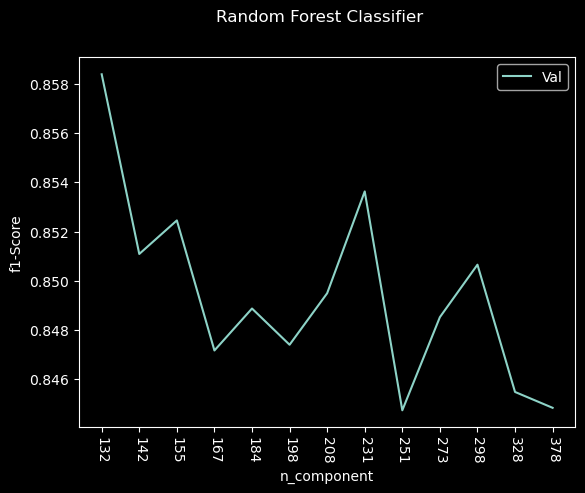

Maximum Validation F1-Score:  0.8583984616578709


In [20]:
from sklearn.ensemble import RandomForestClassifier
np.random.seed(10)

val_f1_scores = []

print('Training:')
for n_component in tqdm(n_components):

    clf = RandomForestClassifier(n_jobs=-1).fit(data['train'][0][:,:n_component], data['train'][1])

    val_preds = clf.predict(data['val'][0][:,:n_component])

    val_f1_scores.append(f1_score(data['val'][1], val_preds, average='macro'))

plt.plot(range(1, len(val_f1_scores)+1), val_f1_scores, label = 'Val')
plt.xticks(range(1, len(n_components)+1), n_components, rotation=-90)
plt.xlabel('n_component')
plt.ylabel('f1-Score')
plt.suptitle('Random Forest Classifier')
plt.legend()
plt.show()

print('Maximum Validation F1-Score: ', max(val_f1_scores))

## Logistic Regression

Training:


  0%|          | 0/13 [00:00<?, ?it/s]/home/sushil/miniconda3/envs/fmnist_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  8%|▊         | 1/13 [03:37<43:27, 217.32s/it]/home/sushil/miniconda3/envs/fmnist_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 15%|█▌        | 2/13 [07:28<41:21, 225.62s/it]/home/sushil/miniconda3/envs/fmnist_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
100%|██████████| 13/13 [37:06<00:00, 171.30s/it]


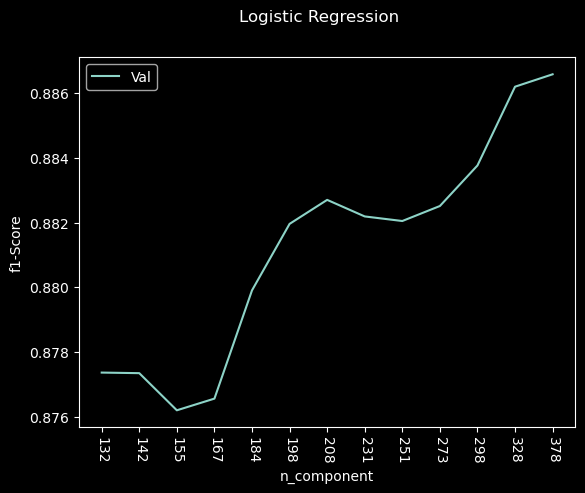

Maximum Validation F1-Score:  0.8865717477464606


In [21]:
from sklearn.linear_model import LogisticRegression
np.random.seed(10)

val_f1_scores = []

print('Training:')
for n_component in tqdm(n_components):

    clf = LogisticRegression(solver='saga', n_jobs=-1, max_iter=500).fit(data['train'][0][:,:n_component], data['train'][1])

    val_preds = clf.predict(data['val'][0][:,:n_component])

    val_f1_scores.append(f1_score(data['val'][1], val_preds, average='macro'))

plt.plot(range(1, len(val_f1_scores)+1), val_f1_scores, label = 'Val')
plt.xticks(range(1, len(n_components)+1), n_components, rotation=-90)
plt.xlabel('n_component')
plt.ylabel('f1-Score')
plt.suptitle('Logistic Regression')
plt.legend()
plt.show()

print('Maximum Validation F1-Score: ', max(val_f1_scores))

## SVM

Training:


100%|██████████| 13/13 [1:27:58<00:00, 406.01s/it]


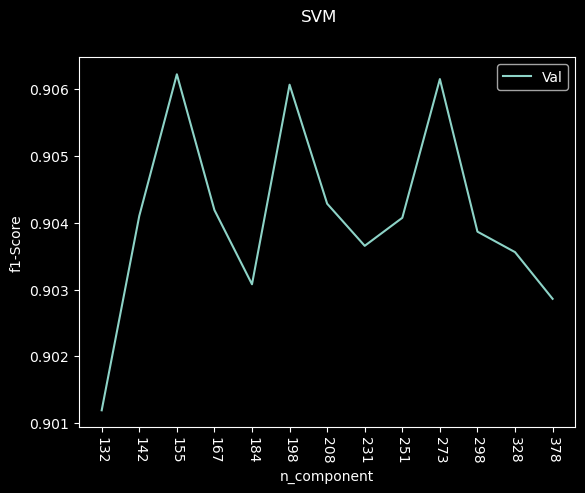

Maximum Validation F1-Score:  0.906224258527042


In [22]:
from sklearn.svm import SVC
np.random.seed(10)

val_f1_scores = []

print('Training:')
for n_component in tqdm(n_components):

    clf = SVC().fit(data['train'][0][:,:n_component], data['train'][1])

    val_preds = clf.predict(data['val'][0][:,:n_component])

    val_f1_scores.append(f1_score(data['val'][1], val_preds, average='macro'))

plt.plot(range(1, len(val_f1_scores)+1), val_f1_scores, label = 'Val')
plt.xticks(range(1, len(n_components)+1), n_components, rotation=-90)
plt.xlabel('n_component')
plt.ylabel('f1-Score')
plt.suptitle('SVM')
plt.legend()
plt.show()

print('Maximum Validation F1-Score: ', max(val_f1_scores))

## Feed Forward Network

In [3]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class fmnist_vit_features_dataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data[1])
    
    def __getitem__(self, index):
        X = self.data[0][index]
        y = torch.zeros(size =(10,))
        y[int(self.data[1][index])] = 1
        return torch.tensor(X), y
    

data = torch.load(feature_path)

X_train, X_val, y_train, y_val = train_test_split(data['train'][0], data['train'][1], test_size = 5000, stratify = data['train'][1], random_state = 10)
data['train'] = [X_train, y_train] 
data['val'] = [X_val, y_val]
        
train_loader = DataLoader(fmnist_vit_features_dataset(data['train']), batch_size= 512, num_workers=10)
val_loader = DataLoader(fmnist_vit_features_dataset(data['val']), batch_size= 512, num_workers=10)
test_loader = DataLoader(fmnist_vit_features_dataset(data['test']), batch_size= 512, num_workers=10)

In [4]:
from torch import nn
torch.random.seed(10)

class FeedForwardNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.linear = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 10),
            nn.Softmax(dim=-1)
        )
    def forward(self, X):
        outs = self.linear(X)
        return outs
    
device = ("cuda" if torch.cuda.is_available() else "cpu")

model = FeedForwardNetwork(data['train'][0].shape[1]).to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters())

num_epochs = 30

FeedForwardNetwork(
  (linear): Sequential(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=512, out_features=10, bias=True)
    (2): Softmax(dim=-1)
  )
)


In [5]:
train_loss = []
train_f1_scores = []

val_loss = []
val_f1_scores = []

print('Training:')
for epoch in tqdm(range(0, num_epochs)):
    running_preds = []
    running_labels = []
    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        with torch.no_grad():
            running_preds.append(pred)
            running_labels.append(y)

    preds, labels = torch.vstack(running_preds), torch.vstack(running_labels)
    train_loss.append(loss_fn(preds, labels).item())
    train_f1_scores.append(f1_score(labels.argmax(-1).cpu(), preds.argmax(-1).cpu(), average='macro'))

    with torch.no_grad():
        running_preds = []
        running_labels = []
        for batch, (X,y) in enumerate(val_loader):
            X, y = X.to(device), y.to(device)

            pred = model(X)

            running_preds.append(pred)
            running_labels.append(y)

        preds, labels = torch.vstack(running_preds), torch.vstack(running_labels)
        val_loss.append(loss_fn(preds, labels).item())   
        val_f1_scores.append(f1_score(labels.argmax(-1).cpu(), preds.argmax(-1).cpu(), average='macro'))

print('Maximum Validation F1-Score: ', max(val_f1_scores))

Training:


100%|██████████| 30/30 [00:34<00:00,  1.14s/it]

Maximum Validation F1-Score:  0.8859191219307545


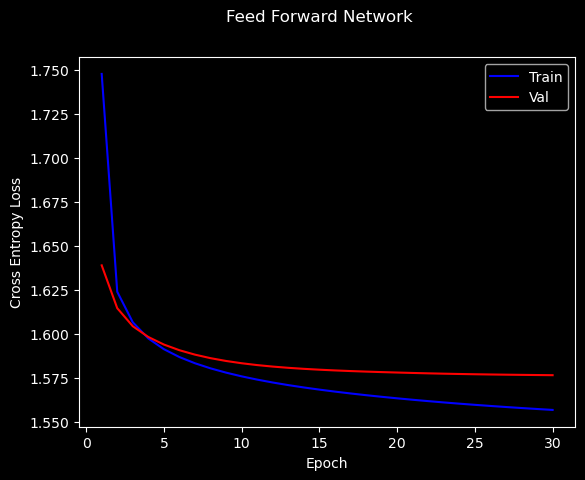

In [6]:
plt.plot(range(1, len(train_loss)+1), train_loss, label = 'Train', c='blue')
plt.plot(range(1, len(val_loss)+1), val_loss, label = 'Val', c='red')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.suptitle('Feed Forward Network')
plt.legend()
plt.show()

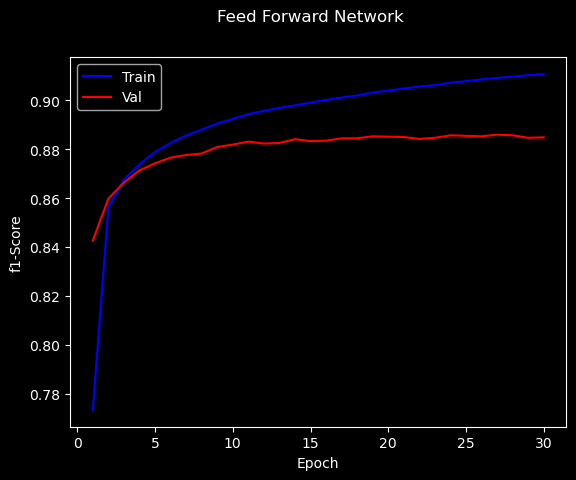

In [7]:
plt.plot(range(1, len(train_f1_scores)+1), train_f1_scores, label = 'Train', c='blue')
plt.plot(range(1, len(val_f1_scores)+1), val_f1_scores, label = 'Val', c='red')
plt.xlabel('Epoch')
plt.ylabel('f1-Score')
plt.suptitle('Feed Forward Network')
plt.legend()
plt.show()